In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import numpy as np  

import tdt
from tdt import read_block, read_sev, epoc_filter, download_demo_data
import elephant
from neo.core import Block, Segment, ChannelIndex, AnalogSignal
import quantities as pq
from quantities import mV, kHz

import scipy
from scipy import signal
import scipy.stats as stat
import itertools
import math
import sys
import copy

import pandas as pd
import datetime as dt
import seaborn as sns


        
plt.style.use('dark_background')

C:\Users\dw2471\Anaconda3\envs\synapse_analysis\lib\site-packages\elephant\pandas_bridge.py:21: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  warnings.warn("pandas_bridge module will be removed in Elephant v0.8.x",


In [87]:

#file = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/Documents - IGM-Makinson Lab/Damian_Data/221019_s3/KCl-221020-121804/Subject1-221020-122317"

##Female het
#file = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/Documents - IGM-Makinson Lab/Damian_Data/221018/221018_s6/KCl-221018-173128/Subject1-221018-173349"

##Female het
#221018_s1
Slice_ID = "221018_s1_Het-F"
file = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/Documents - IGM-Makinson Lab/Damian_Data/221018_het-F/221018_s1/KCl-221018-125545/Subject1-221018-125545"

#file = "C:/Users/dw2471/OneDrive - cumc.columbia.edu/Documents - IGM-Makinson Lab/Damian_Data/221018/221018_s6/KCl-221018-173128/Subject1-221018-181440"




data = read_block(file)


read from t=0s to t=2825.63s


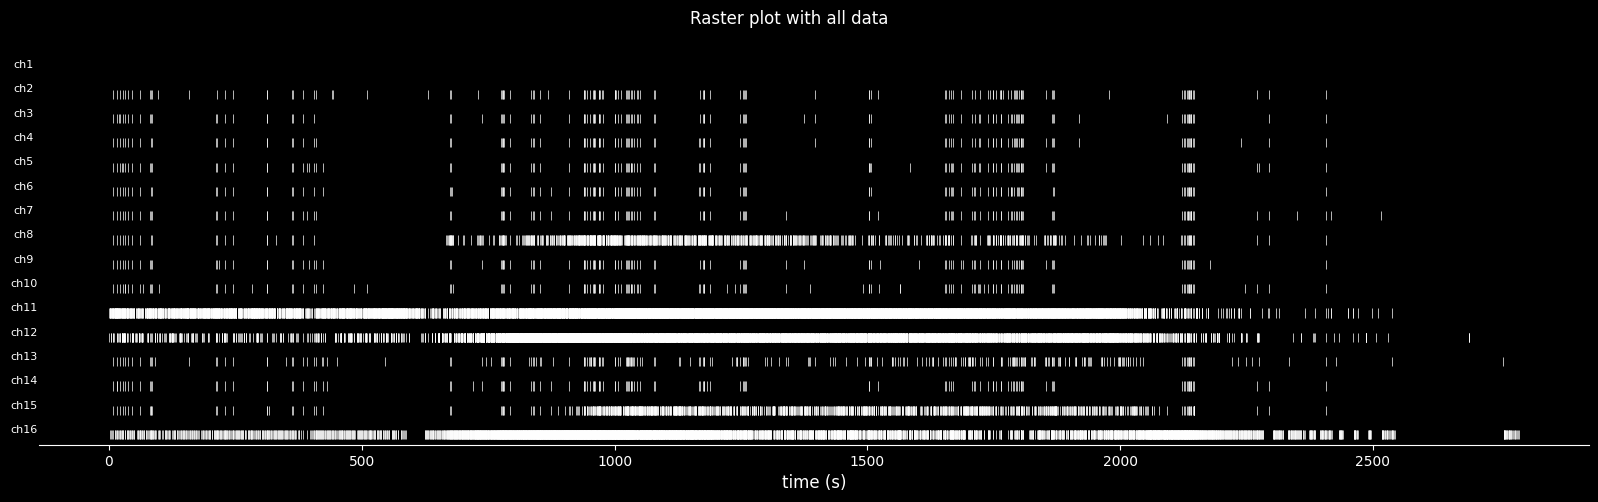

In [770]:

number_of_channels = 16
data_list = data.snips.eNe1.ts[:].tolist()
dat = [x for l in data_list for x in l]
data_list_chan = data.snips.eNe1.chan[:].tolist()
datchan = [x for l in data_list_chan for x in l]
listdata = np.array([dat])
chandata = np.array([datchan])


spike_ts = []
for a in range(number_of_channels):
    temp = []
    temp = [listdata[0][x] for x in range(listdata[0].shape[0]) if chandata[0][x]==a]
    #print(a)
    spike_ts.append(np.array(temp))
    
    
    
#This plots tall

fig, axs = plt.subplots(nrows=number_of_channels, ncols=1, figsize=(20,5), sharex=True)

for a in range(number_of_channels):    
    axs[a].eventplot(spike_ts[a], linelengths = 1, linewidth = 0.5, colors ='w', alpha = 1,lineoffsets=0)
    format_plot(a)    

fig.suptitle('Raster plot with all data')
#plt.xlim((1000.9,1000.95))

# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("GRIN2D_10s_clz_raster_v2.svg")
plt.show()

In [771]:
#For removing all unwanted events based on events in other channels, 
#i.e. will remove all the events in selected channels from every channel

#select noise channels
noise_channels = spike_ts[1:6]

#test_channels = spike_ts[]

#flatten to list of all events in selected channels
noise_spikes = list(itertools.chain(*noise_channels))
print(f'total number of events to remove: {len(noise_spikes)}')

noise_spikes_set = set(noise_spikes)

#remove all occurrences of noise events in all channels


#print(spike_ts_wo_noise)


spike_ts_wo_noise = [[i for i in l if i not in noise_spikes] for l in spike_ts]
    
    
#print(spike_ts_wo_noise)

total number of events to remove: 643


In [772]:
#A function to format the plot, remove axes, etc
def format_plot(channel_number):
    global number_of_channels    
    axs[channel_number].spines['top'].set_visible(False)
    axs[channel_number].spines['right'].set_visible(False)
    axs[channel_number].spines['bottom'].set_visible(False)
    axs[channel_number].tick_params(axis='x', bottom = False)
    axs[channel_number].spines['left'].set_visible(False)
    axs[channel_number].set_yticklabels([])
    axs[channel_number].tick_params(axis='y', left = False)
    text = 'ch'+ str(channel_number+1)
    axs[channel_number].set_ylabel(text, fontsize=8, rotation=0)
    if channel_number==number_of_channels-1:
        axs[channel_number].tick_params(axis='x', bottom = True)
        axs[channel_number].spines['bottom'].set_visible(True)
        axs[channel_number].set_xlabel('time (s)', fontsize = 12)

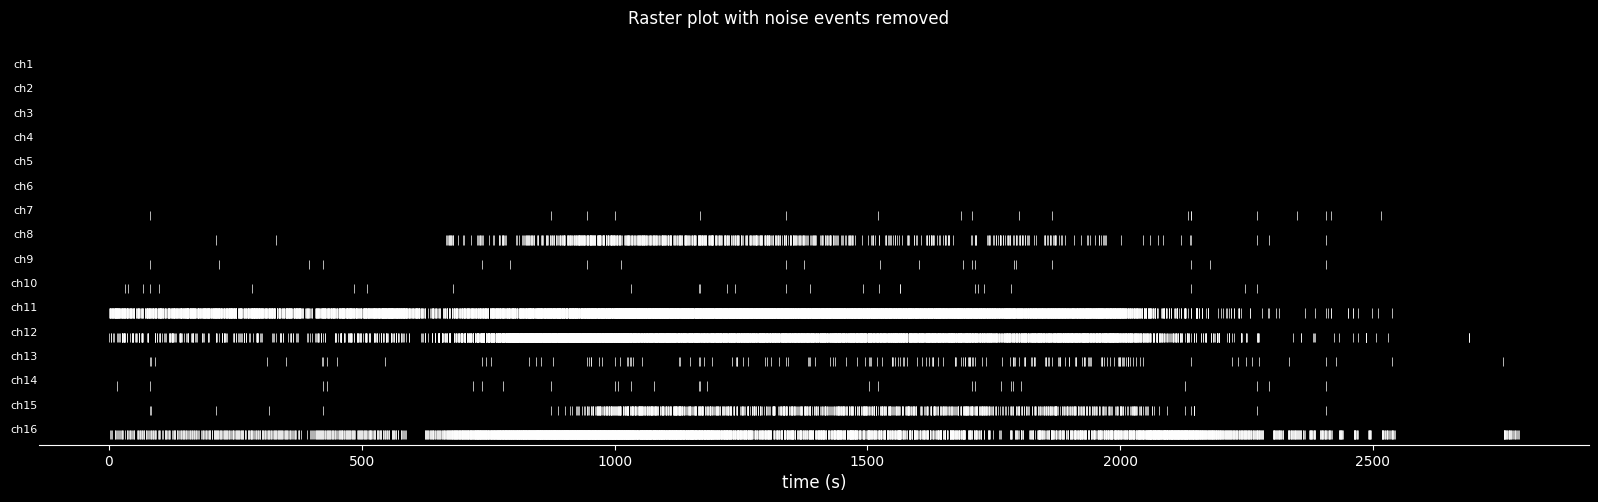

In [749]:
#This plots the spikes without the noise spikes that were identified above

fig, axs = plt.subplots(nrows=number_of_channels, ncols=1, figsize=(20,5), sharex=True)

for a in range(number_of_channels):    
    axs[a].eventplot(spike_ts_wo_noise[a], linelengths = 1, linewidth = 0.5, colors ='w', alpha = 1,lineoffsets=0)
    format_plot(a)    

fig.suptitle('Raster plot with noise events removed')
#plt.xlim((1000.9,1000.95))

"221018_s1_Het-F"

# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("GRIN2D_10s_clz_raster_v2.svg")
plt.show()

In [750]:
channel_of_interest = 11

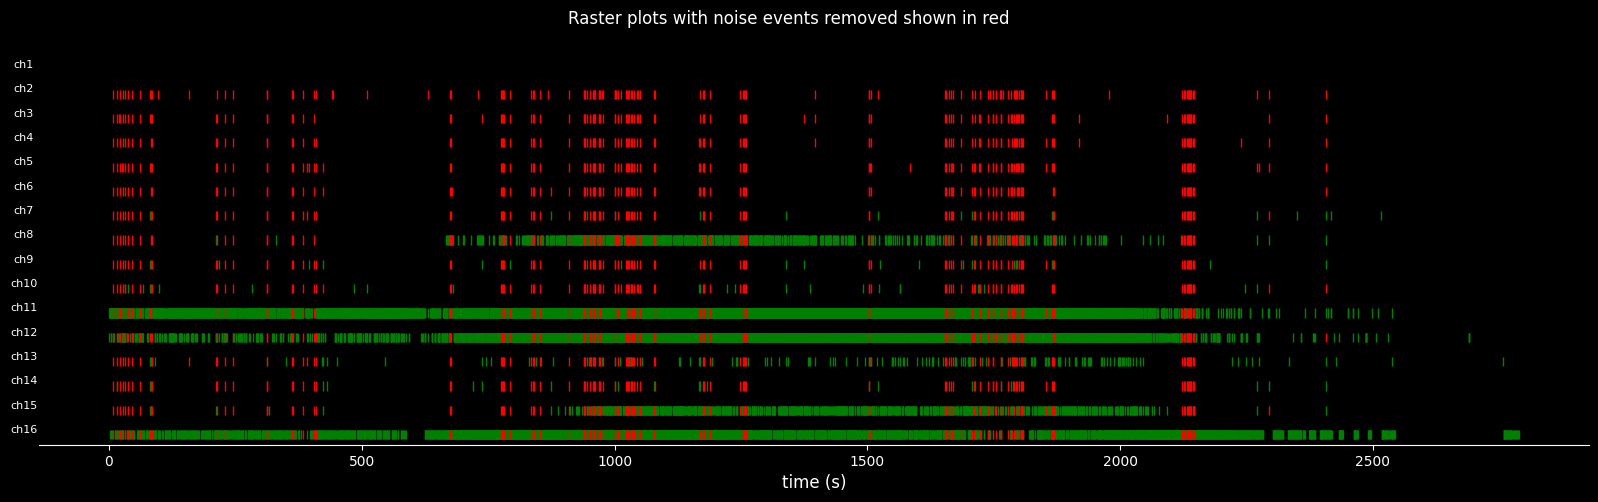

In [773]:
#This plots every spike with the noise spikes shown in red

fig, axs = plt.subplots(nrows=number_of_channels, ncols=1, figsize=(20,5), sharex=True)

#number_of_channels = 3



for a in range(number_of_channels):
    
    #    
    #makes a boolean list showing if the spike is identified as noise
    true_false_noise_spike = ([i in noise_spikes_set for i in spike_ts[a]])    
    
    
    #To be able to color the events, it is necessary to create two lists of events (one for each event type/color)
    current_col = spike_ts[a]    
    real_events = []
    noise = []    
    
    #This loops through each value in the event list and based on the value in the boolean list,
    #add it to a noise list or event list  
    for iteminlist,condition in zip(current_col, true_false_noise_spike):        
        if condition:    
            noise.append(iteminlist)
        else:
            real_events.append(iteminlist)
    
    #Check event numbers of each channel
    """
    print(f"channel number {a}")
    print(f"all from org spike channel {len(current_col)}") 
    print(f"noise spike set {len(noise_spikes_set)}")    
    print(f"all events length {len(true_false_noise_spike)}")
    print(f" noise length {len(noise)}")
    print(f"real_events length {len(real_events)}\n")
    """

    #Plot raster
    events_list = [real_events,noise]    
    axs[a].eventplot(events_list, linelengths = 1, linewidth =1, colors=["g", "r"] , alpha = 1,lineoffsets=0)    
    format_plot(a)    
    
fig.suptitle('Raster plots with noise events removed shown in red')
#plt.xlim((1000.9,1000.95))

# plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_removed_spike_plot.png")

plt.show()




<h2>Poisson Surprise method<h2>

In [764]:
def do_poisson(spikeEvs, minBurstLen, maxInBurstLen, maxBurstIntStart, maxBurstIntTerm, surprise, verbose): 
    
    
    # minBurstLen
    ## Minimum length of spikes to be considered a burst
    
    # maxInBurstLen
    ## Maximum number of spikes within a burst that are evaluated
    ## for increasing Poisson Surprise
    
    # maxBurstIntStart
    ## Maximum ISI required to initiate a burst
    
    # maxBurstIntTerm
    ## Maximum ISI allowed to terminate a burst
    
    # surprise
    ## Minimum Poisson Surprise value
    
    spikeISI = np.diff(spikeEvs)
    
    maxSpikeIntStart = np.average(spikeISI)*maxBurstIntStart
    maxSpikeIntTerm = np.average(spikeISI)*maxBurstIntTerm
    
    avgRate = np.average(1./spikeISI)

    #print "(Min, Max) = (%.3f, %.3f)" % (np.min(spikeISI), np.max(spikeISI))
    

    bursts = []
    activeBurst = [-1,-1]

    ix = 0
    while ix < len(spikeISI):
        isi = spikeISI[ix]
        
        # Initiate burst sequence
        ## Find a spike with ISI < {minSpikeIntStart}
        if activeBurst[0] == -1:
            if isi <= maxSpikeIntStart:
                activeBurst = [ix, ix]
                
                burstExtendForward = 0
                burstRemoveFront = 0
                
                burstExtendForwardSurprise = 0
            
                if verbose > 0:
                    print( "\n\n===== ===== ===== ===== =====")
                    print( "Initiating Burst @ t=%.3f..." % spikeEvs[ix])
                    
                if verbose > 2:
                    print( "\n1: (%i, %i) @ (%.3f, %.3f)" % (activeBurst[0], activeBurst[1], spikeEvs[activeBurst[0]], spikeEvs[activeBurst[1]])
)
            else:
                if verbose > 1:
                    print ("\n--> ISI exceeds max burst onset ISI")
            
        else:
            # Test for minimum burst criterion
            ## {minBurstLen} consecutive spikes have ISI of (AVG ISI)*minBurstIntStart
            
            if isi <= maxSpikeIntTerm:
                if activeBurst[1] - activeBurst[0] < minBurstLen + 1:                    
                    if isi <= maxSpikeIntStart:
                        activeBurst[1] = ix
                        
                        if verbose > 2:
                            print ("\n2: (%i, %i) @ (%.3f, %.3f)" % (activeBurst[0], activeBurst[1], spikeEvs[activeBurst[0]], spikeEvs[activeBurst[1]]))

                        if verbose > 0:
                            print( "Extending initial burst sequence...")
                        
                    else:
                        if verbose > 1:
                            print( "/n--> Initial burst sequence not long enough...")
                        ix = activeBurst[0]
                        activeBurst = [-1,-1]

                else: 
                    # Test for Poisson Surprise criterion in forward direction
                    evCount = activeBurst[1] - activeBurst[0]
                    evTime = spikeEvs[activeBurst[1]] - spikeEvs[activeBurst[0]]
                                        
                    # Calculate probability that n or more spikes are found in sample
                    ## survivorFunc(evCount - 1) is equivalent to "n or more"
                    ## survivorFunc = 1 - cumDistFunc
                    ## cumDistFunc = probability of n or fewer events
                    sf_old = -stat.poisson.logsf(evCount-1, evTime*avgRate)                    
                    
                    temp_ix = ix+1
                    evCount = temp_ix - activeBurst[0]
                    evTime = spikeEvs[temp_ix] - spikeEvs[activeBurst[0]]
                    
                    sf = -stat.poisson.logsf(evCount-1, evTime*avgRate)                    

                    if verbose > 0:
                        print ("\nTesting Poisson Surprise: (%i, %.5f), %.3f (%.3f)" % (evCount, evTime*avgRate, sf, burstExtendForwardSurprise)) 
                        
                    if verbose > 1:
                        print( "Checking Poisson Surprise forward %i..." % burstExtendForward)
                        
                    if verbose > 2:
                        print ("\n3: (%i, %i) @ (%.3f, %.3f)" % (activeBurst[0], temp_ix, spikeEvs[activeBurst[0]], spikeEvs[temp_ix]))
                        
                    

                    if verbose > 3:
                        #print "CDF (old, new): (%.3f, %.3f)" % (-np.log(cdf_old), -np.log(cdf))
                        print ("SF (old, new): (%.3f, %.3f), %.3f" % (sf_old, sf, burstExtendForwardSurprise))
                
                    # Check up to 10 spikes forward to see if Surprise value increases
                    if sf > burstExtendForwardSurprise and burstExtendForward < maxInBurstLen:
                        activeBurst[1] = ix
                        if verbose > 2:
                            print ("Extending burst sequence: (%i, %i)" % (activeBurst[0], activeBurst[1])      )                  
                        
                        burstExtendForward = 0
                        burstExtendForwardSurprise = sf
                        
                    elif burstExtendForward < maxInBurstLen:
                        #activeBurst[1] = ix
                        if verbose > 2:
                            print ("Searching forward: (%i, %i)" % (activeBurst[0], ix+1)    )                    
                        
                        burstExtendForward += 1
                        
                    else:
                        # Test for Poisson Surprise criterion when removing spikes from beginning of burst
                        
                        if verbose > 0:
                            print ("\nRemoving spikes from beginning...")
                            
                        burstRemoveFront = 0
                        i = 1
                        while burstRemoveFront < maxInBurstLen:
                             
                            sf_old = -stat.poisson.logsf(evCount-1, evTime*avgRate)
                            
                            temp_ix = activeBurst[0] + i
                            evCount = activeBurst[1] - temp_ix
                            evTime = spikeEvs[activeBurst[1]] - spikeEvs[temp_ix]
                                                   
                            sf = -stat.poisson.logsf(evCount-1, evTime*avgRate)
                            
                            if verbose > 0:
                                print ("Testing Poisson Surprise: (%i, %.5f), %.3f" % (evCount, evTime*avgRate, sf) )                             

                            if verbose > 3:
                                #print "CDF (old, new): (%.3f, %.3f)" % (-np.log(cdf_old), -np.log(cdf))
                                print ("SF (old, new): (%.3f, %.3f)" % (sf_old, sf))
                             
                            if sf < sf_old:
                                if verbose > 1:
                                    print ("Removing from beginning %i..." % i)
                                
                                burstRemoveFront = 0
                                i += 1
                                continue
                             
                            else:
                                if verbose > 1:
                                    print ("Surprise decreased...")
                                    print ("End of burst?")
                                
                                activeBurst[0] = temp_ix
                                break
                            
                        if verbose > 0:
                            print ("End of burst!!!")
                            print ("\n----- ----- ----- ----- -----")
                        
                        # Check that the surprise value meets minimum surprise parameter and burst contains enough spikes
                        if -np.log(sf) > surprise and activeBurst[1] - activeBurst[0] > minBurstLen:
                            if verbose > 1:
                                print ("Poisson is surprised!")
                            bursts.append(np.array(spikeEvs)[activeBurst])
                        else:
                            if verbose > 1:
                                print ("Failed to meet Poisson Surprise criterion...")
                            ix = activeBurst[0]
                            
                        activeBurst = [-1,-1]
                        
            
            else:
                if verbose > 1:
                    print ("\n--> ISI exceeds max in-burst ISI")
                    print ("\n----- ----- ----- ----- -----")
                                 
                # Check that burst sequence meets minimum burst length                    
                if activeBurst[1] - activeBurst[0] > minBurstLen:
                    if verbose > 0:
                        print ("End of burst!!!")
                        print ("\n----- ----- ----- ----- -----")
                
                    # Test for Poisson Surprise criterion in backwards direction
                    ## Extend burst sequence backwards
                    
                    if verbose > 0:
                        print ("Removing spikes from beginning...")
                        
                    burstRemoveFront = 0
                    i = 1
                    while burstRemoveFront < maxInBurstLen:
                        
                        evCount = activeBurst[1] - activeBurst[0]
                        evTime = spikeEvs[activeBurst[1]] - spikeEvs[activeBurst[0]]                        
                        
                        sf_old = -stat.poisson.logsf(evCount-1, evTime*avgRate)
                        
                        temp_ix = activeBurst[0] + i
                        evCount = activeBurst[1] - temp_ix
                        evTime = spikeEvs[activeBurst[1]] - spikeEvs[temp_ix]
                        
                        sf = -stat.poisson.logsf(evCount-1, evTime*avgRate)
                        
                        if verbose > 0:
                            print ("Testing Poisson Surprise: (%i, %.5f), %.3f" % (evCount, evTime*avgRate, sf)   )                      

                        if verbose > 3:
                            #print "CDF (old, new): (%.3f, %.3f)" % (-np.log(cdf_old), -np.log(cdf))
                            print( "SF (old, new): (%.3f, %.3f)" % (sf_old, sf))
                        
                        if sf < sf_old:
                            if verbose > 2:
                                print ("Removing from beginning %i..." % i)
                            
                            i += 1
                            continue
                            
                        else:
                            if verbose > 1:
                                print ("Surprise decreased...")
                                print ("End of burst?")
                            
                            activeBurst[0] = temp_ix
                            break

                    
                    # Check that burst sequence meets Poisson Surprise criterion
                    
                    evCount = activeBurst[1] - activeBurst[0]
                    evTime = spikeEvs[activeBurst[1]] - spikeEvs[activeBurst[0]]                        
                    
                    sf = -stat.poisson.logsf(evCount-1, evTime*avgRate)                    

                    if verbose > 0:
                        print( "Testing Poisson Surprise: (%i, %.5f), %.3f" % (evCount, evTime*avgRate, sf) )
                        
                    if sf >= surprise and activeBurst[1] - activeBurst[0] > minBurstLen:
                        if verbose > 1:
                            print ("Poisson is surprised!")
                            
                        bursts.append(np.array(spikeEvs[activeBurst]))
                    else:
                        if verbose > 1:
                            print ("Failed to meet Poisson Surprise criterion...")
                            
                        ix = activeBurst[0]
                else:
                    if verbose > 0:
                        print ("Burst sequence too short...")
                    ix = activeBurst[0]
                    
                activeBurst = [-1,-1]
                

        ix += 1
        
        if ix == len(spikeEvs)-1:
            evCount = activeBurst[1] - activeBurst[0]
            evTime = spikeEvs[activeBurst[1]] - spikeEvs[activeBurst[0]]
            sf = -stat.poisson.logsf(evCount-1, evTime*avgRate)
            
            if verbose > 5:
                print ("Final Poisson Surprise test: (%i, %.3f), %.3f" % (evCount, evTime*avgRate, sf)  )          
                
            if sf >= surprise and activeBurst[1] - activeBurst[0] > minBurstLen:
                bursts.append(np.array(spikeEvs)[activeBurst])
            

    if len(bursts) > 0:
        burstsFiltered = [bursts[0]]
        for i in range(len(bursts)-1):
            if burstsFiltered[-1][1] >= bursts[i][0]:
                burstsFiltered[-1][1] = bursts[i][1]
            else:
                burstsFiltered.append(bursts[i])
                
    else:
        burstsFiltered = []
        
    return {'bursts': burstsFiltered,
            'pars': {'minBurstLen': minBurstLen,
                     'maxInBurstLen': maxInBurstLen,
                     'maxBurstIntStart': maxBurstIntStart,
                     'maxBurstIntTerm': maxBurstIntTerm,
                     'surprise': surprise},
            'calcPars': {'avgRate': avgRate,
                         'maxSpikeIntStart': maxSpikeIntStart,
                         'maxSpikeIntTerm': maxSpikeIntTerm} 
            }


    
    """
    from: https://github.com/neuRowsATL/burst-detection/blob/master/lib_final_poisson.py
    """
    


In [765]:
# minBurstLen
## Minimum length of spikes to be considered a burst
    
    # maxInBurstLen
    ## Maximum number of spikes within a burst that are evaluated
    ## for increasing Poisson Surprise
    
    # maxBurstIntStart
    ## Maximum ISI required to initiate a burst
    
    # maxBurstIntTerm
    ## Maximum ISI allowed to terminate a burst
    
    # surprise
    ## Minimum Poisson Surprise value
#Choose data from 
spike_data = np.array(spike_ts_wo_noise[channel_of_interest])
poisson_suprise_results = do_poisson(spike_data, minBurstLen=5, maxInBurstLen=0.2, maxBurstIntStart=0.2, maxBurstIntTerm=0.3, surprise=0.2, verbose=0)    
burst_durations = poisson_suprise_results["bursts"]
print(len(burst_durations))

"""
for x in np.arange(0.00,0.1,0.01):
    poisson_suprise_results = do_poisson(spike_data, minBurstLen=x, maxInBurstLen=0.2, maxBurstIntStart=0.2, maxBurstIntTerm=0.3, surprise=0.2, verbose=0)
    burst_durations = poisson_suprise_results["bursts"]
    print(len(burst_durations))
    
"""



3


'\nfor x in np.arange(0.00,0.1,0.01):\n    poisson_suprise_results = do_poisson(spike_data, minBurstLen=x, maxInBurstLen=0.2, maxBurstIntStart=0.2, maxBurstIntTerm=0.3, surprise=0.2, verbose=0)\n    burst_durations = poisson_suprise_results["bursts"]\n    print(len(burst_durations))\n    \n'

In [767]:
#list of bursts [beginning:end]

print(type(burst_durations))

#convert to tuples for plotting
burst_array_tuples = [tuple(x) for x in burst_durations]

#Create a list of tuples which contain (start of burst,duration of burst)
block_array = []

for chan in burst_array_tuples:    
    new_list = [chan[0],chan[1]-chan[0]]    
    block_array.append(new_list)
    
burst_array_tuples = [tuple(x) for x in block_array]

print(burst_array_tuples[-4:])



<class 'list'>
[(850.24964608, 0.10850303999995958), (902.8130816, 0.314163199999939), (915.87006464, 0.25444351999999526)]


In [768]:
x_lim_start = 900
x_lim_end = 910


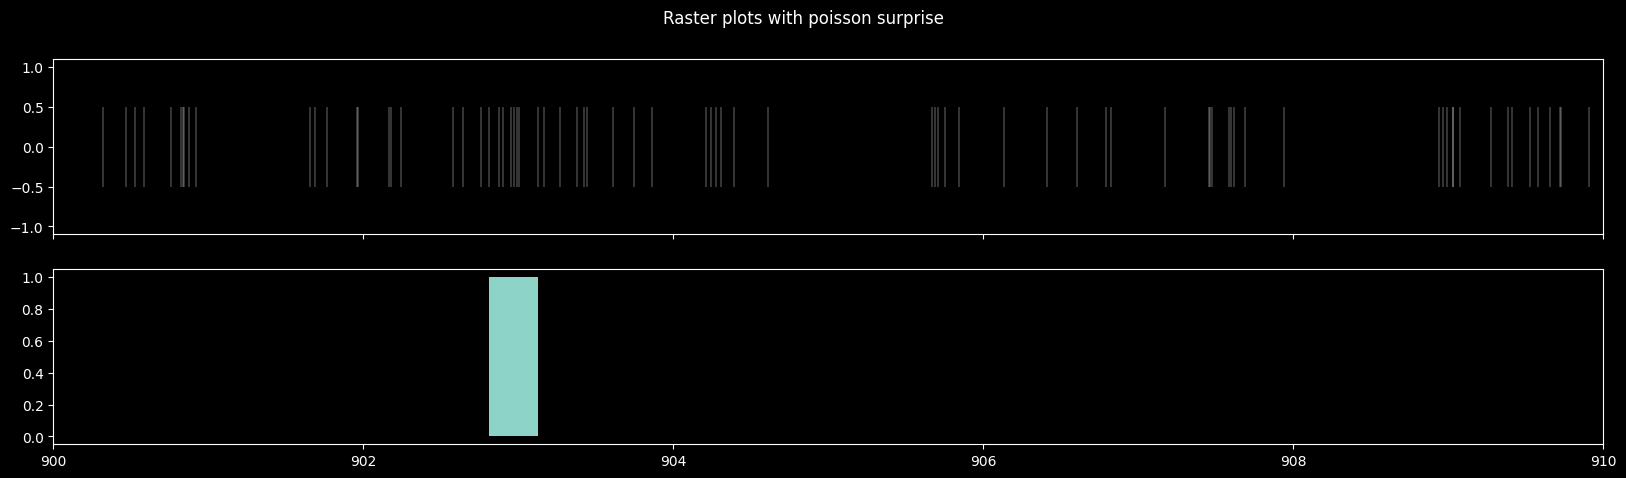

In [769]:
#Plot event detection


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
axs[0].eventplot(spike_ts_wo_noise[channel_of_interest], linelengths = 1, linewidth = 0.3, colors ='w', alpha = 1,lineoffsets=0)
axs[1].broken_barh(burst_array_tuples,(0,1))

#plt.xlim(1000, 1100)

fig.suptitle('Raster plots with poisson surprise')
plt.xlim(x_lim_start,x_lim_end)


plt.savefig("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_burst_figure_poisson.png")


plt.show()



<h2>Interspike interval method v. 1 original<h2>

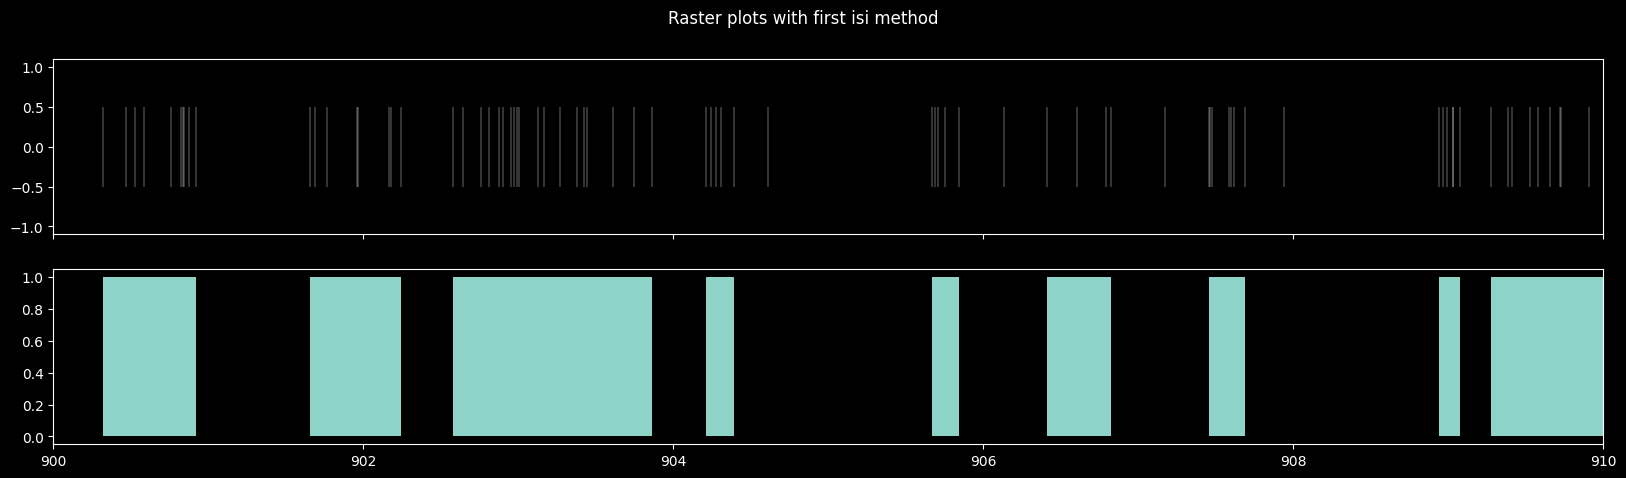

[(29.15454976, 0.09682944000000049), (30.35553792, 0.010854399999999487), (46.45302272, 0.15306752000000046), (58.76588544, 0.002580479999998886), (59.82834688, 0.04796415999999937), (64.66473984, 0.0369049600000011), (65.0135552, 0.18337791999999808), (76.56189952, 0.20463616000000684), (76.67453952, 0.09199616000000788)]


In [774]:
#Other isi burst method

"""
from https://github.com/easy-electrophysiology/easy-electrophysiology-analysis/blob/main/burst_analysis_methods.py


"""

minTime = 100
maxInterval = 200
minNspikes = 2



#2-5 bursts in 100ms, 100ms silent after

spike_times = spike_ts_wo_noise[channel_of_interest]
spike_times = [x * 1000 for x in spike_times]
spike_times = np.array(spike_times)

#print(spike_times)


# first we find the indices of all events that meet the above criteria:
#if len(spike_times) < 3:
    

isis = np.diff(spike_times)

#print(len(isis))

# candidate events with isi more than minimum
burstOnsetCandidates = np.where(isis > minTime)[0].tolist()
burstOnsetCandidates = [x + 1 for x in burstOnsetCandidates]

#print(burstOnsetCandidates)


allBurstList = []
burstOnsetList = []

for i in burstOnsetCandidates:
    tempWithinBurst = [i]  # list of spike times that follow this one
    for j in range(i, len(spike_times) - 1):
        if isis[j] <= maxInterval:  # if interspike interval is long, we terminate
            tempWithinBurst.append(j + 1)  # keep track of spikes that are "within" a burst
        else:  # if isi is too long, terminate burst
            break
    if len(tempWithinBurst) >= (
            minNspikes - 1) and i not in burstOnsetList:  # note, tempWithinBurst does not include the first spike.
        burstOnsetList.append(i)
        allBurstList.append(tempWithinBurst)
        

burstTList = []
burst_positions_isi_1 = []
for j in range(len(allBurstList)):
    burstTList.append(spike_times[allBurstList[j]])
    number_of_spikes = len(spike_times[allBurstList[j]])
    initial_spike = ((spike_times[allBurstList[j]])[0])/1000
    final_spike = ((spike_times[allBurstList[j]])[number_of_spikes-1])/1000
    burst_duration = final_spike-initial_spike
    
    """
    print("**********")
    print(f'spike times:\t{spike_times[allBurstList[j]]}')
    print(f'number of spikes:\t{number_of_spikes+1}')
    print(f'initial spike time:\t{initial_spike}')
    print(f'final spike time:\t{final_spike}')
    """
    
    if(burst_duration > 0):
        #print(f'burst duration:\t{burst_duration}')
        burst_info = (initial_spike,burst_duration)
        burst_positions_isi_1.append(burst_info)
    
    
    
   
    #print(f'spike duration:\t{spikes_duration}\t\tspike times:\t{spike_times[allBurstList[j]]}')

    
#print(burst_positions_isi_1[-4:])

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
axs[0].eventplot(spike_ts_wo_noise[channel_of_interest], linelengths = 1, linewidth = 0.3, colors ='w', alpha = 1,lineoffsets=0)
axs[1].broken_barh(burst_positions_isi_1,(0,1))



fig.suptitle('Raster plots with first isi method')
plt.xlim(x_lim_start,x_lim_end)


plt.savefig("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_burst_figure_isi_1.png",dpi=1200)



plt.show()

print(burst_positions_isi_1[1:10])

<h2>ISI method v. 2<h2>

In [756]:
def detect_burst_start_stop_index(peak_times_ms):
    global params
    """
    
    https://github.com/easy-electrophysiology/easy-electrophysiology-analysis/blob/b5222fd8a62c3bb845500f445359300474eade45/burst_analysis_methods.py
    
    
    
    Entry function for burst detection. Returns the burst start / stop indexes of the peak_times_ms array. U
    Cotterril (2016). A comparison of computational methods for detecting bursts in neuronal spike trains and their
    application to human stem cell-derived neuronal networks. J Neurophysiol. 116(2), 306-321.
    INPUTS:
        peak_times_ms - 1 x N numpy array of peak times in ms
        burst_cfgs - dictionary of options.
            "detection_method" - "interval" or "log_isi" for detection method used.
            "min_spikes_per_burst" - for "log_isi" - the minimum number of spikes in a burst
            "max_short_isi_ms" - for "log_isi" - smaller ISI threshold value (maxISI1)
            "max_long_isi_ms" - for "log_isi" - larger ISI threshold maxlue (maxISI2)
            "interval_params_ms" - dictionary of options for interval method. see calculate_max_interval_method() for details
    OUTPUTS:
        burst_start_idx, burst_stop_idx - start and stop indexes of spikes in peak_times_ms. e.g. if spike times are
                                          1, 2, 3, 5, 10, 15, 20, 21, 22 and spikes 1,2,3 are in burst 1 and 20, 21, 22 in
                                          burst 2, results will be
                                                burst_start_idx = [0, 6]
                                                burst_stop_idx = [2, 8]
    """
    isi_ms = np.diff(peak_times_ms)    
    
    burst_start_idx, burst_stop_idx = calculate_max_interval_method(peak_times_ms,
                                                                        isi_ms,
                                                                        params)  
    
       
    return  burst_start_idx, burst_stop_idx
        

In [757]:
def calculate_max_interval_method(peak_times, isi, params):
    """
    Max interval method, uses the below parameters to detect bursts:

    max_interval            - maximimum ISI interval for spikes in a burst
    max_end_interval        - maximum ISI interval for the last spike of a burst
    min_spikes_per_burst    - minimum number of spikes in a burst
    min_burst_duration
    min_burst_interval

    As desvcribed in: Cotterril (2016). A comparison of computational methods for detecting bursts in neuronal spike trains and their
    application to human stem cell-derived neuronal networks. J Neurophysiol. 116(2), 306-321.
    """
    all_burst_peak_idx = []
    spike_i = 0
    
    #print(len(isi))

    while True:

        if spike_i >= len(isi):
            break

        cur_isi = isi[spike_i]
        
        #print(isi[spike_i])

        if cur_isi <= params["max_interval"]:
            # if the isi is <= than max interval, take it as the first spike of a burst. Below we continue to cycle
            # through isi, if any > max end interval end the burst.

            burst_peak_idx = [spike_i]

            while True:  # cycle through isi looking for end of burst

                spike_i += 1

                if spike_i == len(isi):
                    break

                if isi[spike_i] >= params["max_end_interval"]:
                    break

            burst_peak_idx.append(spike_i)

            burst_start_time, burst_end_time, num_spikes_in_burst = get_burst_times_and_peak_num(peak_times, burst_peak_idx)

            # If burst is longer than one peak, and min burst duration, add to all_burst_peak_idx by updating or merging
            if num_spikes_in_burst >= params["min_spikes_per_burst"] and \
                    burst_end_time - burst_start_time >= params["min_burst_duration"]:  # TODO: test this

                # own function?
                if len(all_burst_peak_idx) >= 1 and \
                        burst_start_time - peak_times[all_burst_peak_idx[-1][-1]] <= params["min_burst_interval"]:  # check previous burst,
                    all_burst_peak_idx[-1][-1] = burst_peak_idx[-1]
                else:
                    all_burst_peak_idx.append(burst_peak_idx)

        spike_i += 1

    if len(all_burst_peak_idx) == 0:
        return False, False

    all_idx = np.array(all_burst_peak_idx)
    start_idx = all_idx[:, 0]
    stop_idx = all_idx[:, 1]
    
    
    
      
    return start_idx ,stop_idx,

In [758]:
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Calculate Burst Parameters
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def get_burst_times_and_peak_num(peak_times, burst_peak_idx):
    
    """
    Get the start / stop times, and num spikes in burst, from peak times
    and a list of indexes that index a burst.
    """
    burst_start_time = round(peak_times[burst_peak_idx[0]])
    burst_end_time = round(peak_times[burst_peak_idx[-1]])
    burst_duration = burst_end_time-burst_start_time
    num_spikes_in_burst = burst_peak_idx[-1] - burst_peak_idx[0] + 1
    #print(num_spikes_in_burst)
    #print(f'start time: {round(burst_start_time)}\tend time: {round(burst_end_time)}\tduration: {round(burst_end_time-burst_start_time)}\tno spikes: {num_spikes_in_burst}')
    
    
    return burst_start_time, burst_end_time, num_spikes_in_burst



def calculate_burst_parameters(peak_times, burst_start_idx, burst_stop_idx):
    
    """
    From the peak times (s), and burst start / stop indexes calculate burst parameters:
    burst_lengths_ms                 - length of each burst in ms
    num_spikes_in_burst              - number of spikes in each burst
    inter_burst_intervals            - interval between bursts (i.e. difference between burst end and next burst start) in ms
    rec_fraction_of_spikes_in_burst  - percent of all spikes that are in a burst (these parameters are calculated per record)
    all_burst_idx                    - index of every spike in burst (indexes peak_times) (list of lists, sublist contains burst indexes)
    all_burst_peak_times             - time of every peak for every spike in each burst (list of lists, sublist contains burst peak times)
    all_intra_burst_ISI              - average ISI of spikes within each burst (list of scalar)
    """
    
    
    burst_lengths_ms = peak_times_ms[burst_stop_idx] - peak_times_ms[burst_start_idx]
    num_spikes_in_burst = burst_stop_idx - burst_start_idx + 1
    inter_burst_intervals = peak_times_ms[burst_start_idx[1:]] - peak_times_ms[burst_stop_idx[:-1]]
    rec_fraction_of_spikes_in_burst = np.sum(num_spikes_in_burst) / peak_times_ms.size
    burst_time_start = (peak_times_ms[burst_start_idx])   
    burst_time_duration = (peak_times_ms[burst_stop_idx])-peak_times_ms[burst_start_idx]
   
    burst_time = list(zip(burst_time_start, burst_time_duration))   
    all_burst_idx = [np.arange(start_idx, stop_idx + 1) for start_idx, stop_idx in zip(burst_start_idx, burst_stop_idx)]
    all_burst_peak_times = [peak_times[indexes] for indexes in all_burst_idx]
    all_intra_burst_ISI = [np.mean(np.diff(bust_peak_times)) for bust_peak_times in all_burst_peak_times]  # burst peak times must be in s later, so this awkward conversion needed
    #print(f'burst det ={burst_time_start},{burst_lengths_ms}')
    return (burst_time_start,burst_lengths_ms)
   


In [759]:
#burst parameters 
"""
max_interval            - maximimum ISI interval for spikes in a burst
max_end_interval        - maximum ISI interval for the last spike of a burst
min_spikes_per_burst    - minimum number of spikes in a burst
min_burst_duration
min_burst_interval
"""

params= {"max_interval":100,
   "max_end_interval":100,
   "min_spikes_per_burst":5,    
    "min_burst_interval":200,
    "min_burst_duration":100}

peak_times = np.array(spike_times)

peak_times_ms = peak_times






burst_start_idx, burst_stop_idx = detect_burst_start_stop_index(peak_times_ms)

#print(burst_start_idx,burst_stop_idx)



burst_time_start,burst_lengths_ms = calculate_burst_parameters(peak_times_ms, burst_start_idx,burst_stop_idx)

#print(burst_time_start,burst_lengths_ms)

burst_time = np.array(burst_time_start)/1000
burst_length = np.array(burst_lengths_ms)/1000

isi_method_2_burst_times = list(zip(burst_time,burst_length))






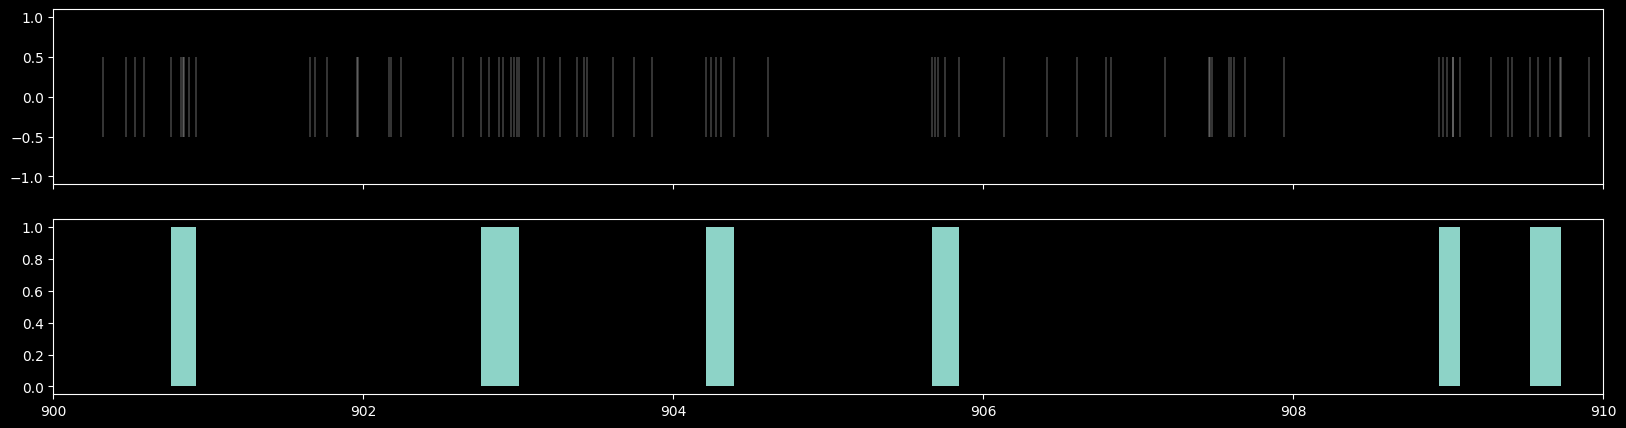

In [760]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,5), sharex=True)
axs[0].eventplot(spike_ts_wo_noise[channel_of_interest], linelengths = 1, linewidth = 0.3, colors ='w', alpha = 1,lineoffsets=0)
axs[1].broken_barh(isi_method_2_burst_times,(0,1))

plt.xlim(x_lim_start,x_lim_end)

plt.savefig("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_burst_figure_isi_2.png",dpi=1200)

plt.show()

<h3>Spike time counts plot<h3>

[2529.23097088, 2690.53763584, 2690.58138112, 2690.61398528]
                 spike_count
time_points                 
0 days 00:00:00            1
0 days 00:00:20            7
0 days 00:00:40           18
0 days 00:01:00           15
0 days 00:01:20           12
...                      ...
0 days 00:43:40            0
0 days 00:44:00            0
0 days 00:44:20            0
0 days 00:44:40            0
0 days 00:45:00            3

[136 rows x 1 columns]


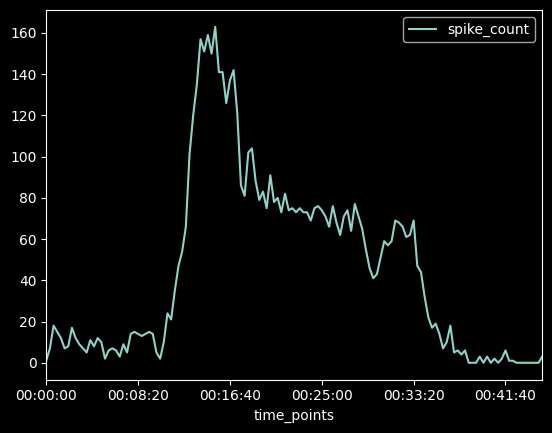

In [763]:
#Add a spike at zero at the start of the data so binning periods start at zero
spike_times_orig = spike_ts_wo_noise[channel_of_interest]
spike_times_zero = copy.deepcopy(spike_times_orig)
spike_times_zero.insert(0,0)

#print(spike_times_zero[-4:])

spike_conv_times= pd.to_timedelta(spike_times_zero, unit='s')
spike_df = pd.DataFrame(spike_conv_times.values,columns =['time_points'])
spike_df['spike_count'] = 1
spike_df_binned = spike_df.set_index('time_points').resample('20S', label='right', closed='right').sum()

slice_id = "ps"

spike_df_binned.to_csv("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_spike_bins.txt",sep='\t')
spike_df_binned.plot().get_figure().savefig("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_spike_plot.png", dpi=1200)


print(spike_df_binned)


<h3> Burst time counts plot<h3>

[1454.35877376, 1478.46279168, 2195.20671744, 2485.67074816]


(1980201.24672, -1978220413.70624)

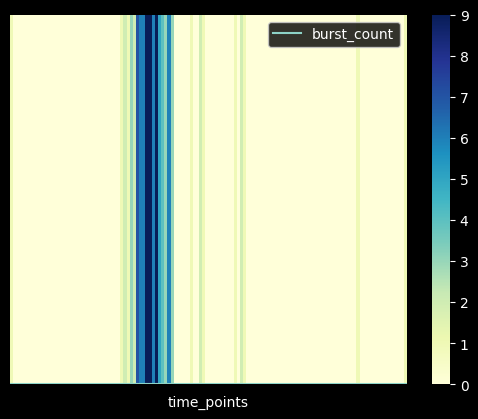

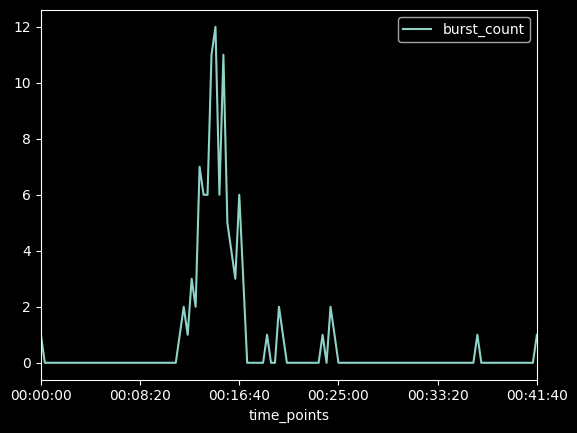

In [762]:

bursts = isi_method_2_burst_times
#bursts = burst_positions_isi_1
#print(f"isi {bursts[-4:]}")
#bursts = burst_positions_ps
#print(f"ps {bursts[-4:]}")


burst_times = [i[0] for i in bursts]
burst_times.insert(0,0)

print(burst_times[-4:])


burst_series = pd.Series(burst_times)

burst_conv_times= pd.to_timedelta(burst_series, unit='s')



burst_df = pd.DataFrame(burst_conv_times.values,columns =['time_points'])
burst_df['burst_count'] = 1
burst_df_binned = burst_df.set_index('time_points').resample('20S', label='right', closed='right').sum()

burst_df_binned.plot()


burst_df_binned_t = burst_df_binned.transpose()

sns.heatmap(burst_df_binned_t, robust=True, cmap='YlGnBu', yticklabels=False, xticklabels=False, cbar=True)

burst_df_binned.to_csv("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_burst_bins.txt",sep='\t')
burst_df_binned.plot().get_figure().savefig("C:/Users/dw2471/Dropbox/IGM projects/SCN8A/Data/Field_potential_data/Spontaneous_activity/"+slice_id+"_burst_plot.png", dpi=1200)







burst_times_zero.pop(len(burst_times_zero)-1)






In [745]:
#Plot spikes and bursts on the same axis


only_spikes = list(spike_df_binned['spike_count'])


print(len(only_spikes))

#burst_df_binned['spike_count'] = only_spikes

print(len(burst_df_binned))


"""

df = burst_df_binned.reset_index()
combined = pd.melt(df, id_vars='time_points', value_vars=['burst_count', 'spike_count'])


#print(burst_df_binned)

sns.lineplot(data=combined, x='time_points', y='value', hue='variable')

print(combined)



"""
   

136
126


"\n\ndf = burst_df_binned.reset_index()\ncombined = pd.melt(df, id_vars='time_points', value_vars=['burst_count', 'spike_count'])\n\n\n#print(burst_df_binned)\n\nsns.lineplot(data=combined, x='time_points', y='value', hue='variable')\n\nprint(combined)\n\n\n\n"

In [292]:
bursts = burst_positions_isi_1




###
#bursts = bursts.append(tuple((0.0,0.0)))
print(bursts)



[(3.30108928, 0.0), (4.00191488, 0.0), (7.96450816, 0.0), (10.07620096, 0.0), (16.40218624, 0.0), (18.57019904, 0.0), (20.60460032, 0.0), (21.81861376, 0.0), (25.07153408, 0.0), (25.8719744, 0.0), (26.119168, 0.0), (26.70604288, 0.11931648000000195), (28.2464256, 0.0), (29.15454976, 0.09682944000000049), (29.46228224, 0.0), (30.35553792, 0.010854399999999487), (30.857707519999998, 0.0), (31.56180992, 0.0), (34.72216064, 0.0), (35.89165056, 0.0), (41.63280895999999, 0.0), (45.10314496, 0.0), (46.45302272, 0.15306752000000046), (47.22765824, 0.0), (47.77324544, 0.0), (52.0036352, 0.0), (52.86948864, 0.0), (53.41945856, 0.0), (54.99764736, 0.0), (58.76588544, 0.002580479999998886), (59.82834688, 0.04796415999999937), (60.12030976, 0.0), (63.847424, 0.0), (64.66473984, 0.0369049600000011), (65.0135552, 0.0), (65.19693312, 0.0), (66.15773184, 0.0), (67.26434816, 0.0), (75.60269824, 0.0), (76.56189952, 0.0), (76.67453952, 0.09199616000000788), (90.41973248, 0.028057600000011007), (91.5299532

In [177]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
series = read_csv('C:/Users/dw2471/Downloads/daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='A'))
years = DataFrame()
print(groups)

C:\Users\dw2471\AppData\Local\Temp\ipykernel_21440\4170052786.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('C:/Users/dw2471/Downloads/daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


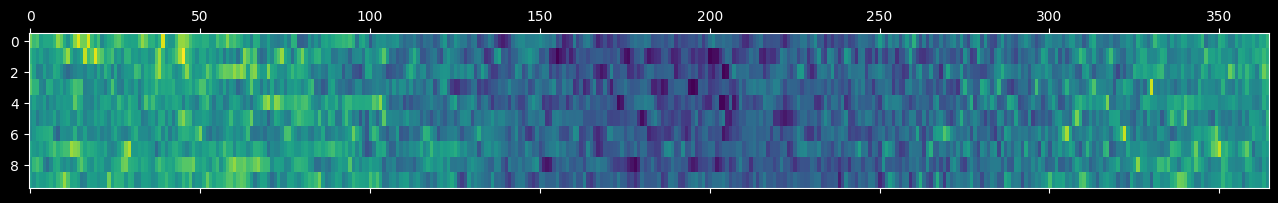

In [178]:
for name, group in groups:
    years[name.year] = group.values
years = years.T
pyplot.matshow(years, interpolation=None, aspect='auto')
pyplot.show()